In [1]:
! pip install segmentation_models
! pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 MB 9.1 MB/s eta 0:00:00:00:0100:01


In [2]:
# Model stuff
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.utils import normalize
import segmentation_models as sm
from sklearn.model_selection import train_test_split
import model_utility
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

#path sorting
import glob
import cv2
from pathlib import Path
import re

#math
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

# What are we doing today?

In [12]:
model_path = "models/"
type = "both"
training_size = "170"
epoch_num = "300"
backbone = "resnet34"

# Create training data

In [6]:
X, Y = [], []

X, Y = model_utility.data_gather(X, Y, "light_spokes_training_images", "light_spokes_training_masks", aug_flag = 1, aug_num = 3)

560 560


In [23]:
X = normalize(np.array(X), axis=1)
Y = (np.array(Y))/255.

# train/test split test_size = .15 for light, .25 for dark(no agu)
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)

SIZE_Y, SIZE_X = X.shape[1], X.shape[2]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1020, 160, 736)
(180, 160, 736)
(1020, 160, 736)
(180, 160, 736)


In [10]:
model = model_utility.define_model(SIZE_Y, SIZE_X, backbone)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 160, 736, 1  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 160, 736, 1)  3           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 166, 742, 1)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 80, 368, 64)  3136        ['zero_padding2d[0][0]']   

In [24]:
history = model_utility.fit_model(x_train, y_train, model, batch_size = 64, epochs = 300, validation_split = .13)

Epoch 1/300
14/14 [==============================] - 20s 1s/step - loss: 0.1979 - iou_score: 0.0522 - val_loss: 14.6642 - val_iou_score: 0.0157
Epoch 2/300
14/14 [==============================] - 13s 955ms/step - loss: 0.1229 - iou_score: 0.0763 - val_loss: 14.0724 - val_iou_score: 0.0159
Epoch 3/300
14/14 [==============================] - 13s 957ms/step - loss: 0.0902 - iou_score: 0.1153 - val_loss: 0.3532 - val_iou_score: 0.0178
Epoch 4/300
14/14 [==============================] - 13s 958ms/step - loss: 0.0689 - iou_score: 0.1670 - val_loss: 0.3942 - val_iou_score: 0.0250
Epoch 5/300
14/14 [==============================] - 13s 959ms/step - loss: 0.0578 - iou_score: 0.2054 - val_loss: 0.4439 - val_iou_score: 0.0239
Epoch 6/300
14/14 [==============================] - 13s 962ms/step - loss: 0.0500 - iou_score: 0.2479 - val_loss: 0.6348 - val_iou_score: 0.0196
Epoch 7/300
14/14 [==============================] - 13s 958ms/step - loss: 0.0437 - iou_score: 0.2868 - val_loss: 0.2358 - v

# Plots

In [25]:
results = model.evaluate(x_test, y_test)

6/6 [==============================] - 2s 262ms/step - loss: 0.0070 - iou_score: 0.9183


In [27]:
model_utility.save_model(f"{model_path}{type}_spoke_{training_size}im_{epoch_num}e_{backbone}.h5", model, history, results)

Which model is this? - bothAug_spoke_1200im_300e_resnet34.json


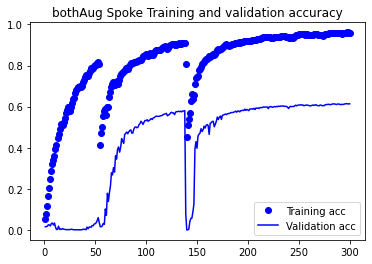

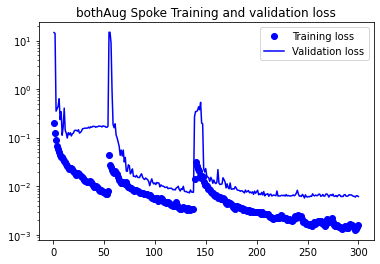

Last Train IOU Score:  0.957347571849823
Last Train Loss Score:  0.0015644058585166931
Last Validation IOU Score:  0.6137905716896057
Last Validation Loss Score:  0.006167583167552948
bothAug
1200
300


In [14]:
model_utility.display_results(f"{model_path}{type}_spoke_{training_size}im_{epoch_num}e_{backbone}.json")
print(type)
print(training_size)
print(epoch_num)

In [ ]:
model_path = "models/"
type = "both"
training_size = "170"
epoch_num = "300"
backbone = "resnet34"

In [13]:
from tensorflow import keras

model = keras.models.load_model(f"../models/{type}_spoke_{training_size}im_{epoch_num}e_{backbone}.h5", compile=False)
print(type)
print(training_size)
print(epoch_num)

bothAug
1200
300


# testing with images outside of train/test(light)

In [ ]:
model_utility.model_testing(model, "dark", 10)

In [122]:
for filename, img in zip(filenames, remaining_test):
    print(filename, filenames.index(f"{filename}.png"))                                         
    plt.imshow(img, cmap="gray")
    plt.show()

    img = img.reshape((1, 160, 736))    
    prediction = model.predict(img)
    prediction = prediction.reshape((160, 736))

    plt.imshow(prediction, cmap='gray')
    plt.show()

    

NameError: name 'filenames' is not defined